## 7 - DETECT IN WHICH ROOM A PICTURE IS TAKEN IN

The problem of detecting in which room a picture is taken in comes down to a classification problem. We will define a list of possible classes (room types). 

We will use VGG-19 as our CNN. But first, we need a respectable dataset so we can train our model well. 

Luckily, [images.cv](https://images.cv) has datasets for bathrooms, bedrooms, dining rooms, kitchens and living rooms. These are the classes that we will use.

Other classes like "home office" or "game room" are unfortunately unavailable but are also less relevant for airbnb listings.

### Setup data

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random

In [3]:
train_path="./drive/MyDrive/images.cv-mit-dataset-no-val-balanced/train"
val_path="./drive/MyDrive/images.cv-mit-dataset/val"

In [ ]:
# kitchen_path = train_path + "/kitchen"
# bedroom_path = train_path + "/bedroom"
# livingroom_path = train_path + "/livingroom"

# kitchen_to_remove = 1000 - 456
# bedroom_to_remove = 1000 - 456
# livingroom_to_remove = 1174 - 456

# while (kitchen_to_remove > 0):
#   os.remove(kitchen_path + "/" + random.choice(os.listdir(kitchen_path)))
#   kitchen_to_remove -= 1

# while (bedroom_to_remove > 0):
#   os.remove(bedroom_path + "/" + random.choice(os.listdir(bedroom_path)))
#   bedroom_to_remove -= 1

# while (livingroom_to_remove > 0):
#   os.remove(livingroom_path + "/" + random.choice(os.listdir(livingroom_path)))
#   livingroom_to_remove -= 1

The datasets were balanced out to roughly have the same amount of images for each class (room type).

In [5]:
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    image_count = len([name for name in os.listdir(sub_path)])
    print("There are " + str(image_count) + " files in the " + folder + " folder.")

There are 456 files in the livingroom folder.
There are 456 files in the kitchen folder.
There are 456 files in the bedroom folder.
There are 676 files in the diningroom folder.
There are 456 files in the bathroom folder.


The code below resizes the images to 224x224.

In [6]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

To normalise, the variables must be devided by 255.0

In [7]:
train_x=np.array(x_train)
train_x=train_x/255.0

Now we compute the labels using ImageDataGenerator. Our images are stored in folders by room name. In this case the folder name is our label.

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

Found 2500 images belonging to 5 classes.


In [10]:
train_y=training_set.classes

training_set.class_indices
train_y.shape 

(2500,)

Note that the shapes of the sets are one dimensional and not one-hot-encoded.

### Setup model

We now set up a VGG-19 model with only 5 classes.

In [11]:
IMAGE_SIZE = [224, 224]

vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


To customize it to 5 classes, we need to add the last layer according to only 5 classes.

In [12]:
x = Flatten()(vgg.output)

prediction = Dense(5, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

View our model:

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Compile and fit model

To avoid overfitting, we will implement an early stopping once the validation loss suddenly starts increasing.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5) #patience of 5 more epochs

In [15]:
from tensorflow import device

with device('/gpu:0'): #make sure gpu is used on Colab

  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
    )

  history = model.fit(
    train_x, 
    train_y, 
    validation_split=0.2,
    epochs=40,
    verbose=1,
    callbacks=[early_stop],
    batch_size=32)

Epoch 1/40
63/63 [==============================] - 56s 586ms/step - loss: 1.3773 - accuracy: 0.4785 - val_loss: 27.5515 - val_accuracy: 0.0400
Epoch 2/40
63/63 [==============================] - 23s 370ms/step - loss: 0.6025 - accuracy: 0.7660 - val_loss: 27.5991 - val_accuracy: 0.0400
Epoch 3/40
63/63 [==============================] - 23s 372ms/step - loss: 0.4783 - accuracy: 0.8245 - val_loss: 28.3363 - val_accuracy: 0.0080
Epoch 4/40
63/63 [==============================] - 23s 371ms/step - loss: 0.4558 - accuracy: 0.8270 - val_loss: 27.9921 - val_accuracy: 0.0420
Epoch 5/40
63/63 [==============================] - 23s 372ms/step - loss: 0.3748 - accuracy: 0.8620 - val_loss: 27.8681 - val_accuracy: 0.0340
Epoch 6/40
63/63 [==============================] - 23s 371ms/step - loss: 0.3403 - accuracy: 0.8710 - val_loss: 27.7557 - val_accuracy: 0.0420
Epoch 00006: early stopping


### View performance of training and validation

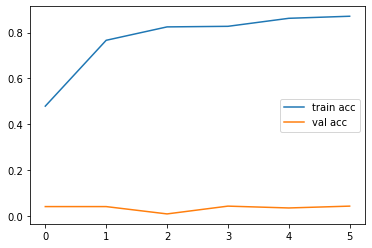

In [16]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

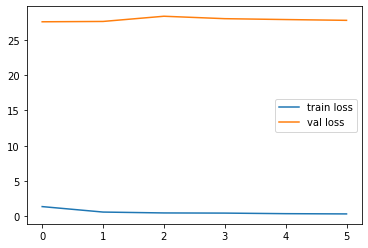

In [17]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

### Evaluate model

The graphs show a significant validation loss and no sign of progress on recognising the validation data. We assumed the VGG 19 is not complex enough for the room classification problem. To illustrate the models incompetence we run it on the given images dataset:

{'bathroom': 0, 'bedroom': 1, 'diningroom': 2, 'kitchen': 3, 'livingroom': 4}


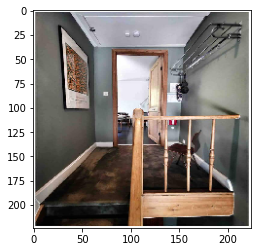

[0. 0. 0. 1. 0.]
kitchen


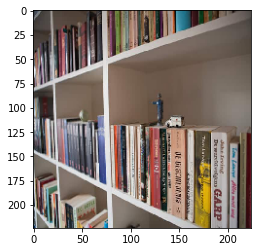

[0. 1. 0. 0. 0.]
bedroom


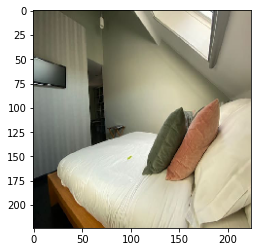

[0.      0.      0.85542 0.14458 0.     ]
diningroom


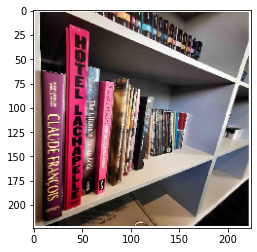

[0. 0. 0. 1. 0.]
kitchen


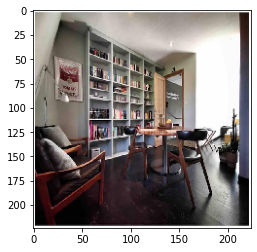

[0.000000e+00 4.832764e-26 0.000000e+00 1.000000e+00 0.000000e+00]
kitchen


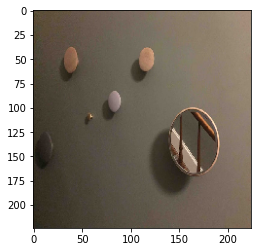

[1. 0. 0. 0. 0.]
bathroom


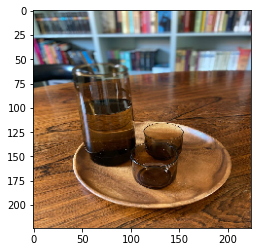

[0. 0. 0. 1. 0.]
kitchen


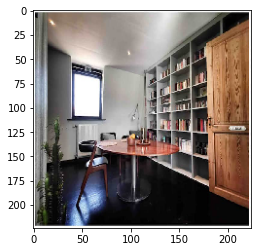

[0.         0.99702483 0.         0.00297518 0.        ]
bedroom


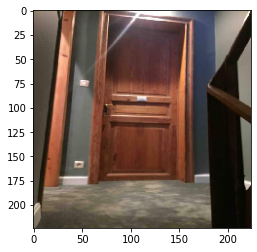

[1.0000000e+00 2.3379428e-27 0.0000000e+00 7.4827478e-11 0.0000000e+00]
bathroom


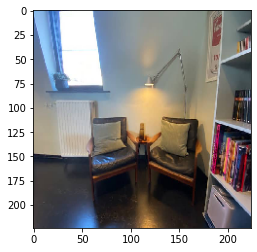

[0. 1. 0. 0. 0.]
bedroom


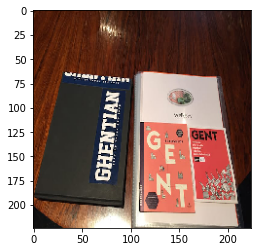

[0. 0. 0. 1. 0.]
kitchen


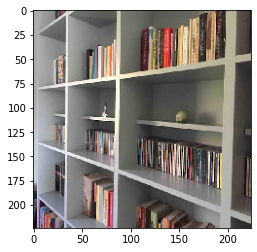

[0. 1. 0. 0. 0.]
bedroom


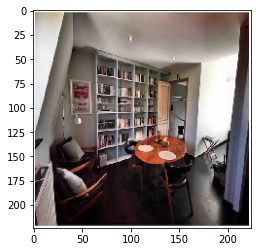

[0. 0. 0. 1. 0.]
kitchen


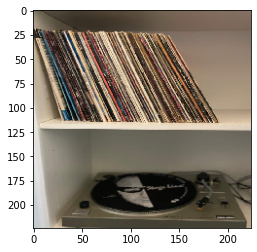

[0.0000000e+00 1.5203057e-14 0.0000000e+00 1.0000000e+00 0.0000000e+00]
kitchen


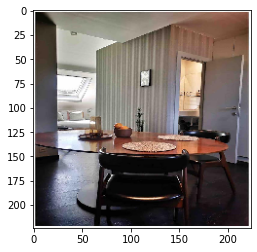

[0. 1. 0. 0. 0.]
bedroom


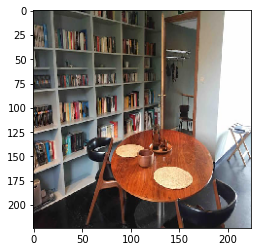

[0.000000e+00 3.056192e-20 0.000000e+00 1.000000e+00 0.000000e+00]
kitchen


In [ ]:
path = "./images_imec/187870"
print(training_set.class_indices)

acceptance_threshold = 0.75

for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    print(pred[0])
    if pred[0][0] > acceptance_threshold:
        print("bathroom")
    elif pred[0][1] > acceptance_threshold:
        print("bedroom")
    elif pred[0][2] > acceptance_threshold:
        print("diningroom")
    elif pred[0][3] > acceptance_threshold:
        print("kitchen")
    elif pred[0][4] > acceptance_threshold:
        print("livingroom")
    else:
        print("Unknown")  

### Reflecting on the VGG 19 results

The results are terrible, despite using all possible hardware resources (maximal Colab RAM use and use of Colab GPU) and a decent amount of training data. Presumably because the problem is too complex for VGG19. We will now try to train a custom Resnet50 model with the same data.

### ResNet50

In [18]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras import models, layers

Again, the top layer will not be included since we only have 5 classes.
Only the last layer will be trained

In [19]:
input_layer=layers.Input(shape=(224,224,3)) #might not be needed since first layer is presumable already this shape
resnet_model=resnet50.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)
resnet_model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

To add our own top layer, we access the current last layer and add a flatten and a dense filter to it.

In [20]:
last_layer=resnet_model.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 

# Add dense layer to the final output layer
output_layer=layers.Dense(5,activation='softmax')(flatten)

# Creating modle with input and output layer
resnet_model2=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
resnet_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Only the last layer should be trainable.

In [21]:
for layer in resnet_model2.layers[:-1]:
    layer.trainable=False
resnet_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

We compile and fit:

In [22]:
from tensorflow import device

with device('/gpu:0'): #make sure gpu is used on Colab

  resnet_model2.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
  )

  batch_size = 32

  resnet_history = resnet_model2.fit(
      train_x,
      train_y,
      validation_split=0.2,
      batch_size = batch_size,

      # steps_per_epoch=int((4000*.75)/batch_size),
      # validation_steps=int((1000*.75)/batch_size),
      # steps_per_epoch=60,
      # validation_steps=12,

      epochs=40,
      verbose=True
      )

Epoch 1/40
63/63 [==============================] - 28s 315ms/step - loss: 2.8573 - accuracy: 0.3195 - val_loss: 77.7446 - val_accuracy: 0.0080
Epoch 2/40
63/63 [==============================] - 17s 263ms/step - loss: 1.5035 - accuracy: 0.3925 - val_loss: 77.8958 - val_accuracy: 0.0120
Epoch 3/40
63/63 [==============================] - 17s 264ms/step - loss: 1.6754 - accuracy: 0.3920 - val_loss: 77.5567 - val_accuracy: 0.0280
Epoch 4/40
63/63 [==============================] - 17s 263ms/step - loss: 1.2808 - accuracy: 0.4955 - val_loss: 78.4547 - val_accuracy: 0.0000e+00
Epoch 5/40
63/63 [==============================] - 17s 265ms/step - loss: 1.4857 - accuracy: 0.4565 - val_loss: 78.8909 - val_accuracy: 0.0140
Epoch 6/40
63/63 [==============================] - 17s 263ms/step - loss: 1.3583 - accuracy: 0.4570 - val_loss: 77.7419 - val_accuracy: 0.0220
Epoch 7/40
63/63 [==============================] - 17s 263ms/step - loss: 1.1470 - accuracy: 0.5205 - val_loss: 77.6096 - val_accur

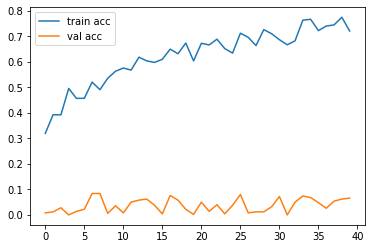

In [23]:
# accuracies

plt.plot(resnet_history.history['accuracy'], label='train acc')
plt.plot(resnet_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

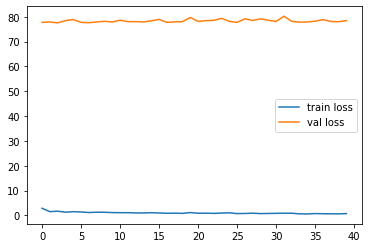

In [24]:
# loss
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

The graphs show a more logical output on the train curves, but the validation loss is high and validation accuracy stays extremely low. 

It is unclear why ResNet50 doesn't perform either.